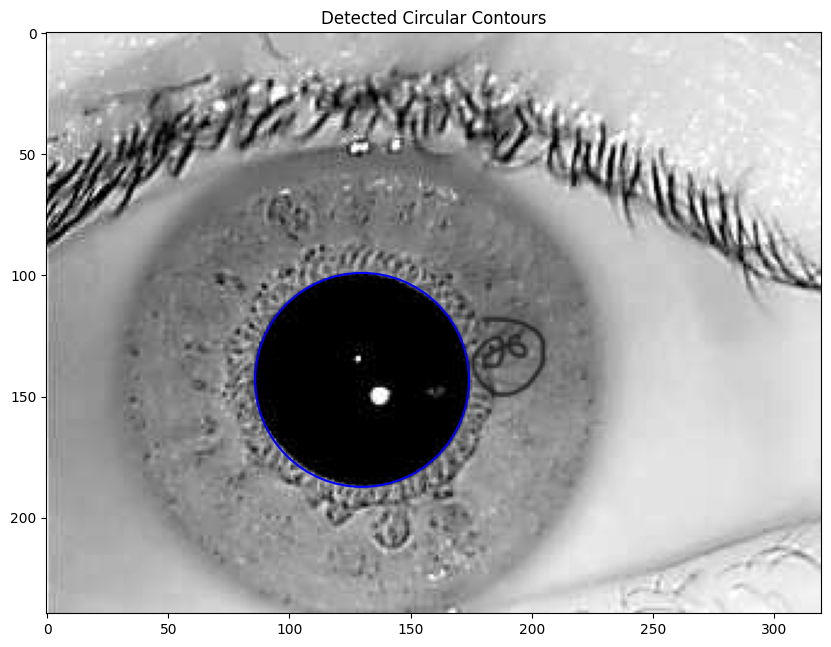

pupil centre: (129.956787109375, 143.12962341308594), pupil radius : 42.15962600708008 


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.signal import find_peaks
from skimage.filters import gaussian
from matplotlib.patches import Circle
from scipy.ndimage import gaussian_filter


# Load the grayscale image
image_path = "01_L.bmp"  # Update this path to the correct image file
image = io.imread(image_path, as_gray=True)


# Convert image to grayscale if it's not already
if len(image.shape) == 3:
    image = color.rgb2gray(image)

# Compute Histogram
hist, bins = np.histogram(image.ravel(), bins=256, range=[0, 1])

# Find peaks in the histogram
peaks, _ = find_peaks(hist, prominence=0.1)  # Adjust prominence as needed
if len(peaks) == 0:
    raise ValueError("No peaks found in the histogram.")
lowest_peak_intensity = bins[peaks][0]  # The first peak is the lowest intensity peak

# Choose a threshold slightly above the lowest peak intensity
threshold = lowest_peak_intensity + 0.01  # Adjust this value if necessary

# Apply Gaussian filter, keep sigma >= 1.5
sigma = 2  # Standard deviation for Gaussian kernel
smoothed_image = gaussian(image, sigma=sigma)

# Create a binary image using the threshold
binary_image = np.where(smoothed_image < threshold, 0, 255).astype(np.uint8)

# Invert the binary image for morphological operations
inverted_binary = cv2.bitwise_not(binary_image)

# Define a kernel for morphological operations (9x9)
kernel = np.ones((9, 9), np.uint8)

# Perform morphological closing to fill holes
closed_image = cv2.morphologyEx(inverted_binary, cv2.MORPH_CLOSE, kernel)

# Invert the image back to original binary format
binary_image = cv2.bitwise_not(closed_image)

# Apply the Canny edge detector
#edges = cv2.Canny(binary_image, threshold1=threshold, threshold2=255)
# Find contours in the binary edge image using OpenCV
contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# Visualize only the circular contours on the original image
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')

pupil_centre =None
pupil_radius = None
# Loop through each contour and check if it is circular
for contour in contours:
    # Fit a minimum enclosing circle to the contour
    (x, y), radius = cv2.minEnclosingCircle(contour)
    
    # Calculate the area of the contour and the circle
    contour_area = cv2.contourArea(contour)
    circle_area = np.pi * (radius ** 2)
    
    # Check if the contour is circular and ignore small 
    if 0.7<= contour_area / circle_area <= 1.2 and radius>=20:  # Adjust the range as necessary
        contour = contour.squeeze()  # Remove extra dimensions
        #plt.plot(contour[:, 1], contour[:, 0],linewidth=2, color='red')  # Corrected indexing
        pupil_centre = (x,y)
        pupil_radius = radius
        # Optionally, draw the enclosing circle on the plot
        circle = plt.Circle((x, y), radius+2, color='blue', fill=False, linewidth=1.5)
        plt.gca().add_patch(circle)

plt.title('Detected Circular Contours')
plt.show()

print(f"pupil centre: {pupil_centre}, pupil radius : {pupil_radius} ")



Max Difference: [0.34594643], Best Radius: 106
Center: (130, 143), Radius: 106


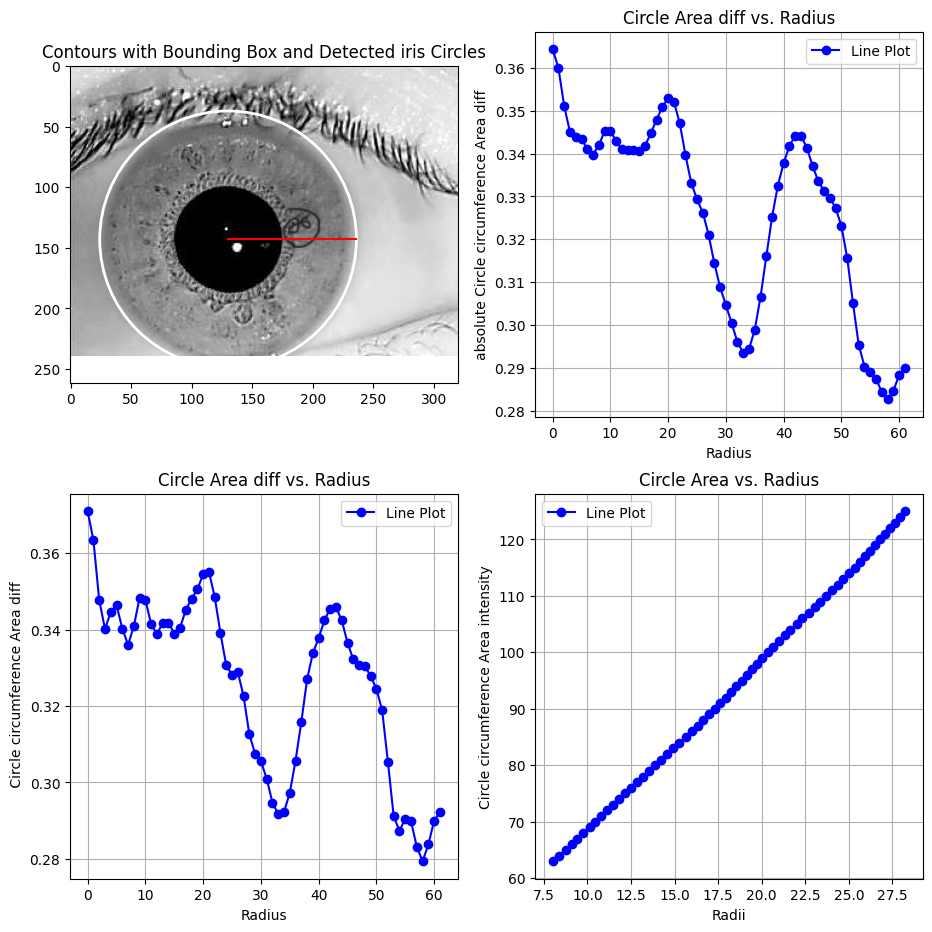

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.ndimage import gaussian_filter
import math

def daugman_operator(gray_img: np.ndarray, center: tuple,
                     r_min: int, r_max: int, step: int = 1):
    """ This function performs the Integrodifferential operator suggested by Daugman and 
        returns the area and radius of the circular region with the maximum density transition.

        gray_img: input grayscale image
        center: The center point of the circle is denoted as (x, y).
        r_daugh_min = pupil radius detected through doughman algo
        r_min: The minimum value of the circle radius for iteration.
        r_max: The maximum value of the circle radius for iteration.
        step: The distance between circles with the same center.
    """
    circle_areas = []
    r_min = pupil_radius + pupil_radius//2  
    mask = np.zeros_like(gray_img, dtype=np.uint8)
    rads = list(range(r_min, r_max, step))
    circles_area =[]
    for r in rads:
        # Draw a filled circle on the mask
        cv2.circle(mask, center, r, 255, thickness=-1)  # Filled circle mask
        circle_img = cv2.bitwise_and(gray_img, gray_img, mask=mask)
        
        circle_area = np.sum(circle_img) / (2*math.pi * r )
        circle_areas.append(circle_area)
        circles_area.append((circle_area,r))
        mask.fill(0)  # Reset mask
    circle_areas = np.array(circle_areas, dtype=np.float32)
    area_diffs = circle_areas[1:] - circle_areas[:-1]
    
    # Apply Gaussian filter to smooth the derivative
    area_diffs = (cv2.GaussianBlur(area_diffs, (1, 5), 0))
    area_diff_abs =(cv2.GaussianBlur(area_diffs, (1, 5), 0))  # some works fine with abs, and some without ab
    # Find the index of the maximum value in the filtered differences
   
    
    #finding radii that detectes iris completly in a range
    value_to_find = 2* pupil_radius + (pupil_radius // 2) 
    
    start_radii = next((i for i, x in enumerate(rads) if x >= value_to_find), None)

    value_to_find1 = 2* pupil_radius + (pupil_radius // 2)+10
    # Find the radius where radius  are greater than or equal to two and a half times pupil radius
    end_radii = next((i for i, x in enumerate(rads) if x >= value_to_find1), None)
    
    idx = np.argmax(area_diffs[start_radii:end_radii])+len(area_diffs[:start_radii])  

      
    return area_diffs[idx], rads[idx],area_diffs,area_diff_abs, circles_area





center_x, center_y = pupil_centre
center_x = int(round(center_x))
center_y = int(round(center_y))  # Ensure this is correctly assigned
pupil_radius = int(round(pupil_radius))  #radius detected by my own algo

max_radius = 3 * pupil_radius 
step_size = 1


# Find the best circle parameters
max_diff, best_radius, area_diff,area_diff_abs,circles_areas= daugman_operator(image, (center_x, center_y),pupil_radius, max_radius, step_size)


# Print results
print(f"Max Difference: {max_diff}, Best Radius: {best_radius}")
print(f"Center: ({center_x}, {center_y}), Radius: {best_radius}")

# Plot the results
fig, ax = plt.subplots(2,2,figsize=(11, 11))
ax[0][0].imshow(image, cmap='gray')

# Draw the detected circle
circle = Circle((center_x, center_y), best_radius, color='white', fill=False, linewidth=2)
ax[0][0].add_patch(circle)

# Draw the radius of the circle as a red line
ax[0][0].plot([center_x, center_x + best_radius], [center_y, center_y], 'r-')

# Set the title and show the plot
ax[0][0].set_title('Contours with Bounding Box and Detected iris Circles')
ax[0][0].axis('image')



# Create a figure and axis for plotting
radius = [i for i in range(0,len(area_diff))]
# Line Plot
ax[1][0].plot(radius, area_diff, marker='o', linestyle='-', color='b', label='Line Plot')

# Scatter Plot (optional)
# ax.scatter(radii, areas, color='r', label='Scatter Plot')

# Add labels and title
ax[1][0].set_xlabel('Radius')
ax[1][0].set_ylabel(' Circle circumference Area diff')
ax[1][0].set_title('Circle Area diff vs. Radius')
ax[1][0].legend()
ax[1][0].grid(True)

# Create a figure and axis for plotting
radius = [i for i in range(0,len(area_diff_abs))]
# Line Plot
ax[0][1].plot(radius, area_diff_abs, marker='o', linestyle='-', color='b', label='Line Plot')

# Scatter Plot (optional)
# ax.scatter(radii, areas, color='r', label='Scatter Plot')

# Add labels and title
ax[0][1].set_xlabel('Radius')
ax[0][1].set_ylabel('absolute Circle circumference Area diff')
ax[0][1].set_title('Circle Area diff vs. Radius')
ax[0][1].legend()
ax[0][1].grid(True)

radii, area = zip(*circles_areas)
ax[1][1].plot(radii, area, marker='o', linestyle='-', color='b', label='Line Plot')

# Scatter Plot (optional)
# ax.scatter(radii, areas, color='r', label='Scatter Plot')

# Add labels and title
ax[1][1].set_xlabel('Radii')
ax[1][1].set_ylabel('Circle circumference Area intensity')
ax[1][1].set_title('Circle Area vs. Radius')
ax[1][1].legend()
ax[1][1].grid(True)

# Show plot
plt.show()




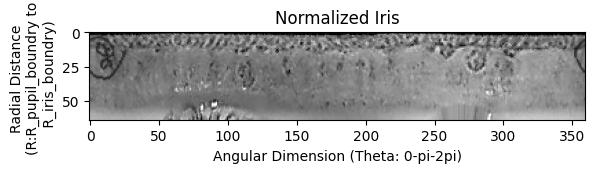

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def daugman_rubber_sheet(image, center, radius_inner, radius_outer):
    """
    Perform Daugman's rubber sheet model normalization on the iris region.
    
    image: Input iris image (grayscale).
    center: Tuple of (x, y) coordinates of the pupil center.
    radius_inner: Radius of the pupil (inner boundary).
    radius_outer: Radius of the iris (outer boundary).
    polar_rows: Number of rows in the normalized image (radial resolution). increase in polar rows capture more pixel, means more resolution normalized image
    polar_cols: Number of columns in the normalized image (angular resolution).
    """
    polar_rows = radius_outer - radius_inner  #radius from pupil to limbic bounry or iris boundry
    polar_cols = 360
    height, width = image.shape[:2]
    
    # Generate theta values from 3:15 (252°) to 2:00 (30°) o'clock counterclockwise
    theta = np.linspace( 2 * np.pi,0, polar_cols)
    # Generate r values from 0 (pupil boundary) to 1 (iris boundary)
    r = np.linspace(0, 1, polar_rows)

    # Create a meshgrid for polar coordinates
    r, theta = np.meshgrid(r, theta)

    # Calculate x and y coordinates based on Daugman's rubber sheet model
    x = center[0] + (1 - r) * radius_inner * np.cos(theta) + r * radius_outer * np.cos(theta)
    y = center[1] + (1 - r) * radius_inner * np.sin(theta) + r * radius_outer * np.sin(theta)

    # Ensure x and y coordinates are within image boundaries
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # Map the original image to the normalized polar coordinates using remap
    #interpolation nearest: mape with nearest pixel value 
    normalized_iris = cv2.remap(image, x.astype(np.float32), y.astype(np.float32), cv2.INTER_NEAREST)
    #normalized_iris = cv2.GaussianBlur(normalized_iris, (3, 3), 0)   # to remove noise created due to remaping, but might loss little value in pixels

    
    return normalized_iris



# Example usage
center = pupil_centre # Example center of the iris
radius_inner = pupil_radius # Example radius of the pupil
radius_outer = best_radius  # Example radius of the iris

# Step 1: Normalize the iris using Daugman's rubber sheet model
normalized_iris = daugman_rubber_sheet(image, center, radius_inner, radius_outer)
normalized_iris = np.transpose(normalized_iris)

# Display using matplotlib
plt.imshow(normalized_iris, cmap='gray')
plt.title('Normalized Iris')
plt.xlabel('Angular Dimension (Theta: 0-pi-2pi)')
plt.ylabel('Radial Distance \n(R:R_pupil_boundry to \n R_iris_boundry)')
plt.axis('on')  # Hide axis labels
plt.show()
 


(64, 360)


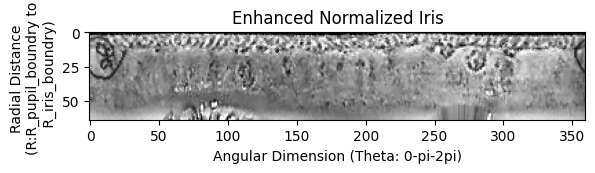

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def daugman_rubber_sheet(image, center, radius_inner, radius_outer):
    """
    Perform Daugman's rubber sheet model normalization on the iris region.
    
    image: Input iris image (grayscale).
    center: Tuple of (x, y) coordinates of the pupil center.
    radius_inner: Radius of the pupil (inner boundary).
    radius_outer: Radius of the iris (outer boundary).
    polar_rows: Number of rows in the normalized image (radial resolution).
    polar_cols: Number of columns in the normalized image (angular resolution).
    """
    polar_rows = radius_outer - radius_inner
    polar_cols = 360
    height, width = image.shape[:2]
    
    # Generate theta values from 0 to 2*pi (angular component) in counter clockwise
    theta = np.linspace( 2*np.pi, 0 , polar_cols)
    
    # Generate r values from 0 (pupil boundary) to 1 (iris boundary)
    r = np.linspace(0, 1, polar_rows)

    # Create a meshgrid for polar coordinates
    r, theta = np.meshgrid(r, theta)

    # Calculate x and y coordinates based on Daugman's rubber sheet model
    x = center[0] + (1 - r) * radius_inner * np.cos(theta) + r * radius_outer * np.cos(theta)
    y = center[1] + (1 - r) * radius_inner * np.sin(theta) + r * radius_outer * np.sin(theta)

    # Ensure x and y coordinates are within image boundaries
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # Map the original image to the normalized polar coordinates using remap
    normalized_iris = cv2.remap(image, x.astype(np.float32), y.astype(np.float32), cv2.INTER_NEAREST)
    #normalized_iris = cv2.GaussianBlur(normalized_iris, (3, 3), 0)   # to remove n
    return normalized_iris

# Example usage
center = pupil_centre  # Example center of the iris
radius_inner = pupil_radius  # Example radius of the pupil
radius_outer = best_radius  # Example radius of the iris

# Step 1: Normalize the iris using Daugman's rubber sheet model
normalized_iris = daugman_rubber_sheet(image, center, radius_inner, radius_outer)
normalized_iris = np.transpose(normalized_iris)

# Normalize floating-point image to [0, 255] range
iris_normalized_uint8 = cv2.normalize(normalized_iris, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_iris = clahe.apply(iris_normalized_uint8)
print(enhanced_iris.shape)
# Display the enhanced normalized iris using matplotlib
plt.imshow(enhanced_iris, cmap='gray')
plt.title('Enhanced Normalized Iris')
plt.xlabel('Angular Dimension (Theta: 0-pi-2pi)')
plt.ylabel('Radial Distance \n(R:R_pupil_boundry to \n R_iris_boundry)')
plt.axis('on')  # Show axis labels
plt.show()



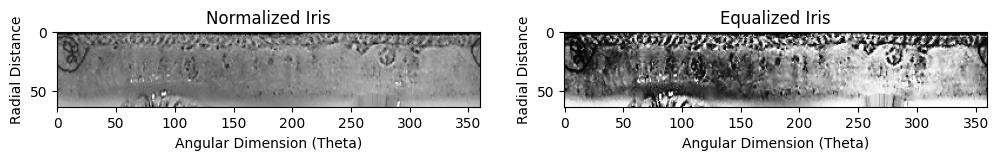

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def daugman_rubber_sheet(image, center, radius_inner, radius_outer):
    """
    Perform Daugman's rubber sheet model normalization on the iris region.
    
    image: Input iris image (grayscale).
    center: Tuple of (x, y) coordinates of the pupil center.
    radius_inner: Radius of the pupil (inner boundary).
    radius_outer: Radius of the iris (outer boundary).
    polar_rows: Number of rows in the normalized image (radial resolution). Increase in polar rows captures more pixels, hence more resolution.
    polar_cols: Number of columns in the normalized image (angular resolution).
    """
    polar_rows = radius_outer - radius_inner
    polar_cols = 360  # Number of angular divisions
    height, width = image.shape[:2]
    
    # Generate theta values from 0 to 2*pi (angular component)
    theta = np.linspace(2 * np.pi,0, polar_cols)  # Counterclockwise from 360 - 0 radians
    
    # Generate r values from 0 (pupil boundary) to 1 (iris boundary)
    r = np.linspace(0, 1, polar_rows)

    # Create a meshgrid for polar coordinates
    r, theta = np.meshgrid(r, theta)

    # Calculate x and y coordinates based on Daugman's rubber sheet model
    x = center[0] + (1 - r) * radius_inner * np.cos(theta) + r * radius_outer * np.cos(theta)
    y = center[1] + (1 - r) * radius_inner * np.sin(theta) + r * radius_outer * np.sin(theta)

    # Ensure x and y coordinates are within image boundaries
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # Map the original image to the normalized polar coordinates using remap
    normalized_iris = cv2.remap(image, x.astype(np.float32), y.astype(np.float32), cv2.INTER_NEAREST)
    
    return normalized_iris

# Example usage
center = pupil_centre  # Example center of the iris
radius_inner = pupil_radius  # Example radius of the pupil
radius_outer = best_radius  # Example radius of the iris



# Step 1: Normalize the iris using Daugman's rubber sheet model
normalized_iris = daugman_rubber_sheet(image, center, radius_inner, radius_outer)
normalized_iris = np.transpose(normalized_iris)
# Normalize floating-point image to [0, 255] range
normalized_iris_uint8 = cv2.normalize(normalized_iris, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Apply histogram equalization
equalized_iris = cv2.equalizeHist(normalized_iris_uint8)

# Display the enhanced normalized iris using matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(normalized_iris_uint8, cmap='gray')
plt.title('Normalized Iris')
plt.xlabel('Angular Dimension (Theta)')
plt.ylabel('Radial Distance')
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(equalized_iris, cmap='gray')
plt.title('Equalized Iris')
plt.xlabel('Angular Dimension (Theta)')
plt.ylabel('Radial Distance')
plt.axis('on')

plt.show()


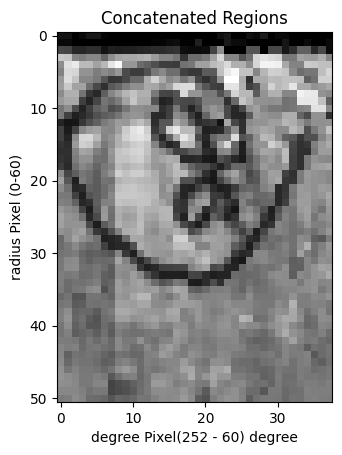

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming `enhanced_iris` is your input image
height, width = enhanced_iris.shape

# Define the indices for extraction
rows_start, rows_end = 0, 50
cols_start_1, cols_end_1 = 352, width #3:00 to 3:15 = 7.5 r
cols_start_2, cols_end_2 = 0, 30  #3:00 to 2:00 = 30 r

# Extract the regions
region1 = enhanced_iris[rows_start:rows_end + 1, cols_start_1:cols_end_1]
region2 = enhanced_iris[rows_start:rows_end + 1, cols_start_2:cols_end_2]

# Ensure the regions have the same number of rows for horizontal concatenation
# Adding padding to `region2` if necessary to match the height of `region1`
if region1.shape[0] > region2.shape[0]:
    padding_height = region1.shape[0] - region2.shape[0]
    region2 = np.pad(region2, ((0, padding_height), (0, 0)), mode='constant', constant_values=0)

# Concatenate the regions horizontally
new_image = np.hstack((region1, region2))

# Display the new image
plt.imshow(new_image, cmap='gray')
plt.title('Concatenated Regions')
plt.xlabel('degree Pixel(252 - 60) degree')
plt.ylabel('radius Pixel (0-60)')
plt.axis('on')  # Show axis labels
plt.show()


In [7]:
import cv2
import numpy as np

# Assuming `enhanced_iris` is your input image
height, width = enhanced_iris.shape

# Define the indices for extraction
rows_start, rows_end = 0, 60
cols_start_1, cols_end_1 = 352, width
cols_start_2, cols_end_2 = 0, 30

# Extract the regions
region1 = enhanced_iris[rows_start:rows_end + 1, cols_start_1:cols_end_1]
region2 = enhanced_iris[rows_start:rows_end + 1, cols_start_2:cols_end_2]

# Ensure the regions have the same number of rows for horizontal concatenation
# Adding padding to `region2` if necessary to match the height of `region1`
if region1.shape[0] > region2.shape[0]:
    padding_height = region1.shape[0] - region2.shape[0]
    region2 = np.pad(region2, ((0, padding_height), (0, 0)), mode='constant', constant_values=0)

# Concatenate the regions horizontally
new_image = np.hstack((region1, region2))

# Display the new image using OpenCV
cv2.imshow('Concatenated Regions', new_image)

# Wait until a key is pressed
cv2.waitKey(0)

# Destroy all OpenCV windows
cv2.destroyAllWindows()


# iris heart part normalization only, efficient

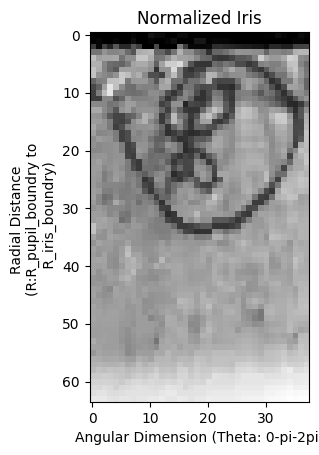

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def daugman_rubber_sheet(image, center, radius_inner, radius_outer):
    """
    Perform Daugman's rubber sheet model normalization on the iris region.
    
    image: Input iris image (grayscale).
    center: Tuple of (x, y) coordinates of the pupil center.
    radius_inner: Radius of the pupil (inner boundary).
    radius_outer: Radius of the iris (outer boundary).
    polar_rows: Number of rows in the normalized image (radial resolution). increase in polar rows capture more pixel, means more resolution normalized image
    polar_cols: Number of columns in the normalized image (angular resolution).
    """
    polar_rows = radius_outer - radius_inner  #radius from pupil to limbic bounry or iris boundry
    polar_cols = 38
    height, width = image.shape[:2]
    
    # Generate theta values from  2:00 to 3:15 (330°)  (360+8°) o'clock clockwise
    theta = np.linspace(np.deg2rad(330), np.deg2rad(360+8), polar_cols)
    # Generate r values from 0 (pupil boundary) to 1 (iris boundary)
    r = np.linspace(0, 1, polar_rows)

    # Create a meshgrid for polar coordinates
    r, theta = np.meshgrid(r, theta)

    # Calculate x and y coordinates based on Daugman's rubber sheet model
    x = center[0] + (1 - r) * radius_inner * np.cos(theta) + r * radius_outer * np.cos(theta)
    y = center[1] + (1 - r) * radius_inner * np.sin(theta) + r * radius_outer * np.sin(theta)

    # Ensure x and y coordinates are within image boundaries
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # Map the original image to the normalized polar coordinates using remap
    #interpolation nearest: mape with nearest pixel value 
    normalized_iris = cv2.remap(image, x.astype(np.float32), y.astype(np.float32), cv2.INTER_NEAREST)
    #normalized_iris = cv2.GaussianBlur(normalized_iris, (3, 3), 0)   # to remove noise created due to remaping, but might loss little value in pixels

    
    return normalized_iris



# Example usage
center = pupil_centre # Example center of the iris
radius_inner = pupil_radius # Example radius of the pupil
radius_outer = best_radius  # Example radius of the iris

# Step 1: Normalize the iris using Daugman's rubber sheet model
normalized_iris = daugman_rubber_sheet(image, center, radius_inner, radius_outer)
normalized_iris = np.transpose(normalized_iris)

# Display using matplotlib
plt.imshow(normalized_iris, cmap='gray')
plt.title('Normalized Iris')
plt.xlabel('Angular Dimension (Theta: 0-pi-2pi)')
plt.ylabel('Radial Distance \n(R:R_pupil_boundry to \n R_iris_boundry)')
plt.axis('on')  # Hide axis labels
plt.show()

#
# Display the new image using OpenCV
cv2.imshow("enhanced heart rejoin", enhanced_iris)

# Wait until a key is pressed
cv2.waitKey(0)

# Destroy all OpenCV windows
cv2.destroyAllWindows()
 


(50, 38)


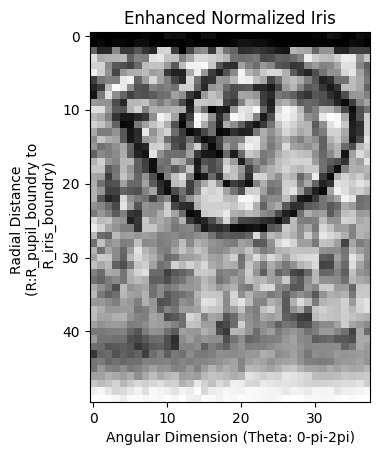

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def daugman_rubber_sheet(image, center, radius_inner, radius_outer):
    """
    Perform Daugman's rubber sheet model normalization on the iris region.
    
    image: Input iris image (grayscale).
    center: Tuple of (x, y) coordinates of the pupil center.
    radius_inner: Radius of the pupil (inner boundary).
    radius_outer: Radius of the iris (outer boundary).
    polar_rows: Number of rows in the normalized image (radial resolution).
    polar_cols: Number of columns in the normalized image (angular resolution).
    """
    polar_rows = radius_outer - radius_inner
    if polar_rows>50:
        polar_rows = 50 
    polar_cols = 38
    height, width = image.shape[:2]
    
    # Generate theta values from 2:00 to 3:15(330°)  (360+8°) o'clock clockwise
    theta = np.linspace(np.radians(330), np.radians(360+8), polar_cols)
    # Generate r values from 0 (pupil boundary) to 1 (iris boundary)
    
    # Generate r values from 0 (pupil boundary) to 1 (iris boundary)
    r = np.linspace(0, 1, polar_rows)

    # Create a meshgrid for polar coordinates
    r, theta = np.meshgrid(r, theta)

    # Calculate x and y coordinates based on Daugman's rubber sheet model
    x = center[0] + (1 - r) * radius_inner * np.cos(theta) + r * radius_outer * np.cos(theta)
    y = center[1] + (1 - r) * radius_inner * np.sin(theta) + r * radius_outer * np.sin(theta)

    # Ensure x and y coordinates are within image boundaries
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # Map the original image to the normalized polar coordinates using remap
    normalized_iris = cv2.remap(image, x.astype(np.float32), y.astype(np.float32), cv2.INTER_NEAREST)
    #normalized_iris = cv2.GaussianBlur(normalized_iris, (3, 3), 0)   # to remove n
    return normalized_iris

# Example usage
center = pupil_centre  # Example center of the iris
radius_inner = pupil_radius  # Example radius of the pupil
radius_outer = best_radius  # Example radius of the iris

# Step 1: Normalize the iris using Daugman's rubber sheet model
normalized_iris = daugman_rubber_sheet(image, center, radius_inner, radius_outer)
normalized_iris = np.transpose(normalized_iris)

# Normalize floating-point image to [0, 255] range
iris_normalized_uint8 = cv2.normalize(normalized_iris, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_iris = clahe.apply(iris_normalized_uint8)
print(enhanced_iris.shape)
# Display the enhanced normalized iris using matplotlib
plt.imshow(enhanced_iris, cmap='gray')
plt.title('Enhanced Normalized Iris')
plt.xlabel('Angular Dimension (Theta: 0-pi-2pi)')
plt.ylabel('Radial Distance \n(R:R_pupil_boundry to \n R_iris_boundry)')
plt.axis('on')  # Show axis labels
plt.show()

# Display the new image using OpenCV
cv2.imshow("enhanced heart rejoin", enhanced_iris)

# Wait until a key is pressed
cv2.waitKey(0)

# Destroy all OpenCV windows
cv2.destroyAllWindows()


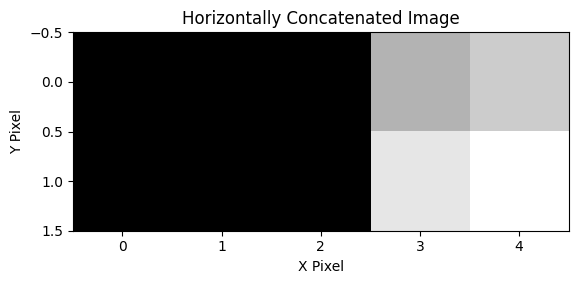

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Example arrays (images) with the same number of rows
region1 = np.array([[0, 0, 0], [0, 0, 0]])
region2 = np.array([[7, 8], [9, 10]])

# Concatenate horizontally
combined_image = np.hstack((region1, region2))

# Display the result
plt.imshow(combined_image, cmap='gray')
plt.title('Horizontally Concatenated Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.axis('on')
plt.show()


# Applying pca

In [13]:
enhanced_iris.shape
import pandas as pd

pd.DataFrame(enhanced_iris)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,15,15,15,15,15,15,15,21,15,15,...,15,15,18,20,34,28,15,15,29,23
1,15,22,15,22,22,15,27,28,15,15,...,15,15,15,15,15,15,15,26,24,15
2,109,51,51,143,68,70,95,64,52,211,...,174,168,110,153,153,50,49,73,75,74
3,226,175,182,183,189,106,138,133,227,233,...,139,238,208,194,190,209,238,233,153,198
4,212,212,145,99,91,76,114,191,199,198,...,70,142,159,138,142,171,225,223,141,105
5,240,209,153,79,157,177,180,190,162,172,...,66,48,89,124,151,151,216,231,167,119
6,73,126,138,133,234,241,109,163,217,168,...,174,134,95,46,60,120,122,192,175,128
7,48,70,190,252,233,149,93,88,137,126,...,140,97,106,65,39,63,191,190,172,108
8,34,128,225,145,110,76,95,89,100,117,...,76,63,96,91,60,42,88,156,158,137
9,158,152,152,87,51,186,187,196,156,131,...,101,114,108,90,85,48,25,74,141,169


In [39]:
from numpy.linalg import eig
#1st )centric to mean for variation stablity in data variables
mean_bycolumn = np.mean(enhanced_iris.T,axis=1)
#print(mean_bycolumn.shape)  #each column mean found

#2nd)  standardazing data
standardized_iris_heart = enhanced_iris - mean_bycolumn
#print(standardized_iris_heart)

#3rd) finding coverence matrix of standardized matrix between each two features to find relationship
coverence_matrix = np.cov(standardized_iris_heart.T)
#print(coverence_matrix)
#4th) find eigen vectors and values of coverence matrix,
#eigen vectors will be new dimentions on which data will be floted,
#eigen values will be percentage variation in data by eigen vector
eigen_values, eigen_vectors = eig(coverence_matrix)
#print(f"eigen_values: {eigen_values} \n eigen vectors:  {eigen_vectors}")

#5th) projection of data on new eigen vectors
projected_data = eigen_vectors.T.dot(standardized_iris_heart.T)
print(projected_data.shape)   
print(projected_data)

(38, 50)
[[-7.81551063e+02 -7.78510712e+02 -3.06537426e+02 ...  4.24226290e+02
   5.71935979e+02  6.32520885e+02]
 [-4.33309003e+01 -6.09298421e+01  6.90912025e+01 ...  6.61247474e+00
   1.21398464e+01  1.57681544e+01]
 [-2.46790337e+01 -2.05511850e+01 -6.69547875e+01 ... -1.53402713e+00
   2.22407386e+01  3.63416191e+01]
 ...
 [-4.28433771e+00  2.68360172e+00  3.02602540e-01 ... -3.72346177e+00
  -2.34094201e+00  1.28055587e+00]
 [ 3.10038760e+00 -3.03415364e+00  5.66543081e+00 ...  2.02172089e-01
  -3.21859828e+00  5.24408924e+00]
 [-4.81095179e+00  3.85217306e+00  1.84750791e-01 ...  2.07526524e+00
   9.85825703e-01 -6.26166772e+00]]


In [63]:
#above pca work of  steps in pca library
from sklearn.decomposition import PCA as pca
pcs = pca(n_components = 20)
pcs_vectors = pcs.fit_transform(enhanced_iris)
#print(pcs_vectors.shape)
#print(pcs_vectors)
# Get the eigenvalues (explained variance)
eigenvalues = pcs.explained_variance_
# Get the explained variance ratio and round it to 2 decimal places
explained_variance_ratio = pcs.explained_variance_ratio_
rounded_variance_ratio = [round(val, 5) for val in sorted(explained_variance_ratio, reverse = True )]
if np.sum(rounded_variance_ratio)>0.9:
    print("ok: 90%")
print("Loaded ratio:", rounded_variance_ratio)
print("Eigenvalues (Lambda values):", eigenvalues)


ok: 90%
Loaded ratio: [0.41087, 0.10283, 0.08076, 0.06335, 0.04735, 0.04273, 0.04149, 0.02925, 0.02661, 0.02153, 0.01973, 0.01707, 0.01386, 0.01231, 0.01168, 0.0096, 0.00797, 0.00687, 0.00525, 0.00427]
Eigenvalues (Lambda values): [53802.19261803 13465.02630725 10575.36590663  8295.37064946
  6200.56604913  5595.17839107  5432.95779553  3830.10119699
  3484.76418326  2819.80360941  2584.13487901  2235.35386117
  1814.49863895  1612.2776585   1530.04366606  1256.86386904
  1043.63038076   899.77617581   687.32741344   559.70241036]


# pca feature reduction main work

In [17]:
import pandas as pd
from sklearn.decomposition import PCA

# selecting number of pcs whose variance ratio sum >=93%
i=10
while i<=enhanced_iris.shape[1]:
    pcs = PCA(n_components=i)
    transformed_data = pcs.fit_transform(enhanced_iris)
    # Get the explained variance ratio of each pc
    explained_variance_ratio = pcs.explained_variance_ratio_
    if np.sum(explained_variance_ratio)>0.93:
        break
    i+=1
        
# Check the shape of transformed_data
print("Shape of transformed_data:", transformed_data.shape)

# Create the DataFrame with the transformed data
pcdf = pd.DataFrame(data=transformed_data)

# Get the eigenvalues (explained variance)
eigenvalues = pcs.explained_variance_

# Generate column names based on the number of principal components
num_components = transformed_data.shape[1]
column_names = [f'pc{i+1}' for i in range(num_components)]

# Assign the column names to the DataFrame
pcdf.columns = column_names

print(pcdf)



Shape of transformed_data: (50, 15)
           pc1         pc2         pc3         pc4         pc5         pc6  \
0  -781.551063   43.330900   24.679034   -8.841593   -5.561881    9.500855   
1  -778.510712   60.929842   20.551185   22.512762  -11.841446   19.340494   
2  -306.537426  -69.091203   66.954788  -75.520820  213.730063   -6.152108   
3   151.145472  -15.119743   44.286439 -225.344169   70.915926   20.122932   
4    18.130587   63.291591  129.962881 -169.630373 -113.167490  122.505555   
5    38.636455   58.526268  129.007669   99.009879 -222.985665   91.314022   
6   -10.378840   84.098670  -61.995051  194.506649   41.296956   60.171523   
7  -155.825894   93.800417 -176.930399  -74.903450   78.819942  122.632658   
8  -207.073938  126.301815  -16.863716   -0.700349  128.975334   35.308458   
9  -104.017073   39.118205  114.519899   56.589731  112.361201  112.453746   
10   14.958670 -206.989971   71.994371  197.454254   23.790753  121.354611   
11   50.084423 -268.321460  

In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def daugman_rubber_sheet(image, center, radius_inner, radius_outer):
    """
    Perform Daugman's rubber sheet model normalization on the iris region.
    """
    polar_rows = radius_outer - radius_inner
    polar_cols = 360
    height, width = image.shape[:2]
    
    # Generate theta values from 0 to 2*pi (angular component)
    theta = np.linspace(0, 2 * np.pi, polar_cols)
    
    # Generate r values from 0 (pupil boundary) to 1 (iris boundary)
    r = np.linspace(0, 1, polar_rows)

    # Create a meshgrid for polar coordinates
    r, theta = np.meshgrid(r, theta)

    # Calculate x and y coordinates based on Daugman's rubber sheet model
    x = center[0] + (1 - r) * radius_inner * np.cos(theta) + r * radius_outer * np.cos(theta)
    y = center[1] + (1 - r) * radius_inner * np.sin(theta) + r * radius_outer * np.sin(theta)

    # Ensure x and y coordinates are within image boundaries
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # Map the original image to the normalized polar coordinates using remap
    normalized_iris = cv2.remap(image, x.astype(np.float32), y.astype(np.float32), cv2.INTER_NEAREST)
    return normalized_iris

def extract_rectangle(image, start_angle_deg, end_angle_deg, min_radius, max_radius):
    """
    Extracts a rectangular part of the image based on angular and radial range.
    """
    polar_rows = 50
    polar_cols = 360
    height, width = image.shape[:2]

    # Convert angles from degrees to radians
    start_angle_rad = np.deg2rad(start_angle_deg)
    end_angle_rad = np.deg2rad(end_angle_deg)

    if end_angle_rad < start_angle_rad:
        end_angle_rad += 2 * np.pi  # Adjust for the wrap-around

    # Create polar coordinates for the extraction region
    theta = np.linspace(start_angle_rad, end_angle_rad, polar_cols)
    r = np.linspace(min_radius / polar_rows, max_radius / polar_rows, polar_rows)

    # Create meshgrid
    r, theta = np.meshgrid(r, theta)

    # Convert polar coordinates to Cartesian coordinates
    x = np.clip((r * np.cos(theta) * (width / 2) + (width / 2)).astype(np.int32), 0, width - 1)
    y = np.clip((r * np.sin(theta) * (height / 2) + (height / 2)).astype(np.int32), 0, height - 1)
    
    # Create an empty output image
    rectangle_part = np.zeros_like(image)

    # Fill the rectangle part with the original image values
    for i in range(len(r)):
        for j in range(len(theta)):
            rectangle_part[y[i, j], x[i, j]] = image[y[i, j], x[i, j]]
    
    return rectangle_part
# Example usage
center = pupil_centre  # Example center of the iris
radius_inner = pupil_radius  # Example radius of the pupil
radius_outer = best_radius  # Example radius of the iris



# Normalize the iris using Daugman's rubber sheet model
normalized_iris = daugman_rubber_sheet(image, center, radius_inner, radius_outer)

# Normalize floating-point image to [0, 255] range
iris_normalized_uint8 = cv2.normalize(normalized_iris, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_iris = clahe.apply(iris_normalized_uint8)

# Extract the rectangular part
rectangle_part = extract_rectangle(enhanced_iris, start_angle_deg=352, end_angle_deg=60, min_radius=0, max_radius=60)

# Display the extracted rectangle
plt.imshow(rectangle_part, cmap='gray')
plt.title('Extracted Rectangle from Normalized Iris')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.axis('on')  # Show axis labels
plt.show()

# Display the enhanced normalized iris using matplotlib
plt.imshow(enhanced_iris, cmap='gray')
plt.title('Enhanced Normalized Iris')
plt.xlabel('Angular Dimension (Theta: 0-pi-2pi)')
plt.ylabel('Radial Distance \n(R:R_pupil_boundry to \n R_iris_boundry)')
plt.axis('on')  # Show axis labels
plt.show()


IndexError: index 50 is out of bounds for axis 1 with size 50

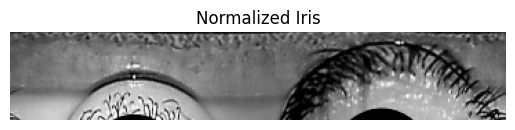

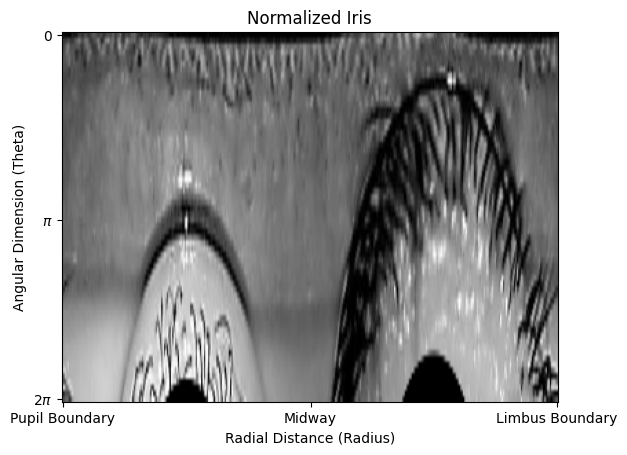

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def normalize_iris(image, center, radius_inner, radius_outer, polar_rows=64, polar_cols=360):
    theta = np.linspace(0, 2 * np.pi, polar_cols)
    r = np.linspace(0, 1, polar_rows)
    r, theta = np.meshgrid(r, theta)

    # Compute x and y coordinates for the normalized iris image
    x = (1 - r) * (center[0] + radius_inner * np.cos(theta)) + r * (center[0] + radius_outer * np.cos(theta))
    y = (1 - r) * (center[1] + radius_inner * np.sin(theta)) + r * (center[1] + radius_outer * np.sin(theta))
    
    # Map the original image to the normalized image using interpolation
    normalized_iris = cv2.remap(image, x.astype(np.float32), y.astype(np.float32), cv2.INTER_LINEAR)
    
    return normalized_iris

# Example usage
center = pupil_centre # Example center of the iris
radius_inner = pupil_radius # Example radius of the pupil
radius_outer = best_radius  # Example radius of the iris

# Step 1: Normalize the iris
normalized_iris = normalize_iris(image, center, radius_inner, radius_outer)
# We transpose the image to flip the axes
normalized_iris = np.transpose(normalized_iris)
# Step 2: Apply Gabor filter
# Define Gabor filter parameters


# Display using matplotlib
plt.imshow(normalized_iris, cmap='gray')
plt.title('Normalized Iris')
plt.axis('off')  # Hide axis labels
plt.show()
# Step 3: Display the normalized iris with correct axis labels
plt.imshow(normalized_iris, cmap='gray', aspect='auto')
plt.title('Normalized Iris')

# Set labels for axes
# X-axis represents the radial distance (radius)
# Y-axis represents the angular dimension (theta)
plt.xlabel('Radial Distance (Radius)')
plt.ylabel('Angular Dimension (Theta)')

# Optionally, set ticks for better interpretation
plt.xticks([0, normalized_iris.shape[1]//2, normalized_iris.shape[1]-1], 
           ['Pupil Boundary', 'Midway', 'Limbus Boundary'])
plt.yticks([0, normalized_iris.shape[0]//2, normalized_iris.shape[0]-1], 
           ['0', r'$\pi$', r'2$\pi$'])
plt.show()


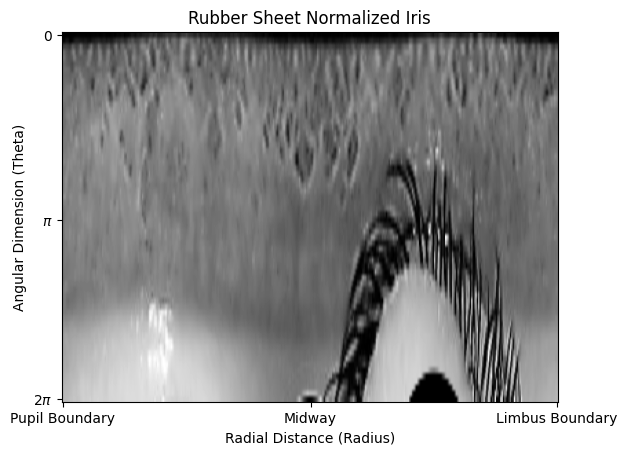

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rubber_sheet_normalization(image, center, radius_inner, radius_outer, polar_rows=64, polar_cols=360):
    """
    Perform rubber sheet normalization on the iris region.
    
    image: Input iris image (grayscale).
    center: Tuple of (x, y) coordinates of the pupil center.
    radius_inner: Radius of the pupil (inner boundary).
    radius_outer: Radius of the iris (outer boundary).
    polar_rows: Number of rows in the normalized image (radial resolution).
    polar_cols: Number of columns in the normalized image (angular resolution).
    """
    height, width = image.shape[:2]
    
    theta = np.linspace(0, 2 * np.pi, polar_cols)
    r = np.linspace(0, 1, polar_rows)

    # Create meshgrid for polar coordinates
    r, theta = np.meshgrid(r, theta)

    # Compute corresponding Cartesian coordinates
    x = (1 - r) * (center[0] + radius_inner * np.cos(theta)) + r * (center[0] + radius_outer * np.cos(theta))
    y = (1 - r) * (center[1] + radius_inner * np.sin(theta)) + r * (center[1] + radius_outer * np.sin(theta))

    # Ensure x and y coordinates are within image boundaries
   
    # Normalize the iris using remap
    normalized_iris = cv2.remap(image, x.astype(np.float32), y.astype(np.float32), cv2.INTER_LINEAR)
    
    return normalized_iris


# Check if the image is loaded correctly
if image is None:
    raise ValueError("Image not loaded. Please check the file path.")

# Example usage
center = pupil_centre # Example center of the iris
radius_inner = pupil_radius # Example radius of the pupil
radius_outer = best_radius  # Example radius of the iris
# Step 1: Normalize the iris using the rubber sheet model
normalized_iris = rubber_sheet_normalization(image, center, radius_inner, radius_outer)

# Step 2: Rotate the normalized image to display radius on x-axis and theta on y-axis
# We transpose the image to flip the axes
normalized_iris_flipped = np.transpose(normalized_iris)

# Display the results using matplotlib
plt.imshow(normalized_iris_flipped, cmap='gray', aspect='auto')
plt.title('Rubber Sheet Normalized Iris')

# Set labels for axes
plt.xlabel('Radial Distance (Radius)')
plt.ylabel('Angular Dimension (Theta)')

# Optionally, set ticks for better interpretation
plt.xticks([0, normalized_iris_flipped.shape[1]//2, normalized_iris_flipped.shape[1]-1], 
           ['Pupil Boundary', 'Midway', 'Limbus Boundary'])
plt.yticks([0, normalized_iris_flipped.shape[0]//2, normalized_iris_flipped.shape[0]-1], 
           ['0', r'$\pi$', r'2$\pi$'])

plt.show()


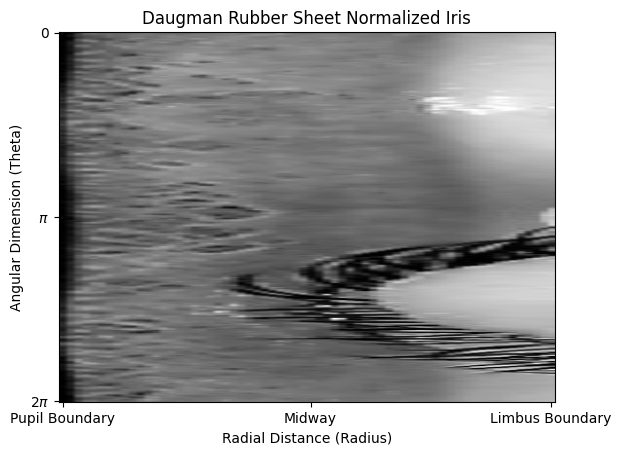

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def daugman_rubber_sheet(image, center, radius_inner, radius_outer, polar_rows=64, polar_cols=360):
    """
    Perform Daugman's rubber sheet model normalization on the iris region.
    
    image: Input iris image (grayscale).
    center: Tuple of (x, y) coordinates of the pupil center.
    radius_inner: Radius of the pupil (inner boundary).
    radius_outer: Radius of the iris (outer boundary).
    polar_rows: Number of rows in the normalized image (radial resolution).
    polar_cols: Number of columns in the normalized image (angular resolution).
    """
    height, width = image.shape[:2]
    
    # Generate theta values from 0 to 2*pi (angular component)
    theta = np.linspace(0, 2 * np.pi, polar_cols)
    
    # Generate r values from 0 (pupil boundary) to 1 (iris boundary)
    r = np.linspace(0, 1, polar_rows)

    # Create a meshgrid for polar coordinates
    r, theta = np.meshgrid(r, theta)

    # Calculate x and y coordinates based on Daugman's rubber sheet model
    x = center[0] + (1 - r) * radius_inner * np.cos(theta) + r * radius_outer * np.cos(theta)
    y = center[1] + (1 - r) * radius_inner * np.sin(theta) + r * radius_outer * np.sin(theta)

    # Ensure x and y coordinates are within image boundaries
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # Map the original image to the normalized polar coordinates using remap
    normalized_iris = cv2.remap(image, x.astype(np.float32), y.astype(np.float32), cv2.INTER_LINEAR)
    
    return normalized_iris

# Check if the image is loaded correctly
if image is None:
    raise ValueError("Image not loaded. Please check the file path.")


# Example usage
center = pupil_centre # Example center of the iris
radius_inner = pupil_radius # Example radius of the pupil
radius_outer = best_radius  # Example radius of the iris
# Step 1: Normalize the iris using the rubber sheet model
# Step 1: Normalize the iris using Daugman's rubber sheet model
normalized_iris = daugman_rubber_sheet(image, center, radius_inner, radius_outer)

# Step 2: Display the normalized iris image with x-axis representing the radial distance and y-axis representing the angular dimension
plt.imshow(normalized_iris, cmap='gray', aspect='auto')
plt.title('Daugman Rubber Sheet Normalized Iris')

# Set labels for axes
plt.xlabel('Radial Distance (Radius)')
plt.ylabel('Angular Dimension (Theta)')

# Optionally, set ticks for better interpretation
plt.xticks([0, normalized_iris.shape[1]//2, normalized_iris.shape[1]-1], 
           ['Pupil Boundary', 'Midway', 'Limbus Boundary'])
plt.yticks([0, normalized_iris.shape[0]//2, normalized_iris.shape[0]-1], 
           ['0', r'$\pi$', r'2$\pi$'])

plt.show()


In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.ndimage import gaussian_filter
import math

def daugman_operator(gray_img: np.ndarray, center: tuple,
                     r_min: int, r_max: int, step: int = 1):
    """ This function performs the Integrodifferential operator suggested by Daugman and 
        returns the area and radius of the circular region with the maximum density transition.

        gray_img: input grayscale image
        center: The center point of the circle is denoted as (x, y).
        r_daugh_min = pupil radius detected through doughman algo
        r_min: The minimum value of the circle radius for iteration.
        r_max: The maximum value of the circle radius for iteration.
        step: The distance between circles with the same center.
    """
    circle_areas = []
    r_min = pupil_radius + pupil_radius//2  
    mask = np.zeros_like(gray_img, dtype=np.uint8)
    rads = list(range(r_min, r_max, step))
    circles_area =[]
    for r in rads:
        # Draw a filled circle on the mask
        cv2.circle(mask, center, r, 255, thickness=-1)  # Filled circle mask
        circle_img = cv2.bitwise_and(gray_img, gray_img, mask=mask)
        
        circle_area = np.sum(circle_img) / (2*math.pi * r )
        circle_areas.append(circle_area)
        circles_area.append((circle_area,r))
        mask.fill(0)  # Reset mask
    circle_areas = np.array(circle_areas, dtype=np.float32)
    area_diffs = circle_areas[1:] - circle_areas[:-1]
    
    # Apply Gaussian filter to smooth the derivative
    area_diffs = (cv2.GaussianBlur(area_diffs, (1, 5), 0))
    area_diff_abs = abs(cv2.GaussianBlur(area_diffs, (1, 5), 0))  # some works fine with abs, and some without ab
    # Find the index of the maximum value in the filtered differences
   
    
    #finding radii that detectes iris completly in a range
    value_to_find = 2* pupil_radius + (pupil_radius // 2) 
    
    start_radii = next((i for i, x in enumerate(rads) if x >= value_to_find), None)
    print(start_radii)
    value_to_find1 = 2* pupil_radius + (pupil_radius // 2)+10
    # Find the radius where radius  are greater than or equal to two and a half times pupil radius
    end_radii = next((i for i, x in enumerate(rads) if x <= value_to_find1), None)
    
    idx = np.argmax(area_diffs[start_radii:end_radii])+len(area_diffs[:start_radii])  

      
    return area_diffs[idx], rads[idx],area_diffs,area_diff_abs, circles_area





center_x, center_y = pupil_centre
center_x = int(round(center_x))
center_y = int(round(center_y))  # Ensure this is correctly assigned
pupil_radius = int(round(pupil_radius))  #radius detected by my own algo

max_radius = 3 * pupil_radius 
step_size = 1


# Find the best circle parameters
max_diff, best_radius, area_diff,area_diff_abs,circles_areas= daugman_operator(image, (center_x, center_y),pupil_radius, max_radius, step_size)


# Print results
print(f"Max Difference: {max_diff}, Best Radius: {best_radius}")
print(f"Center: ({center_x}, {center_y}), Radius: {best_radius}")

# Plot the results
fig, ax = plt.subplots(2,2,figsize=(11, 11))
ax[0][0].imshow(image, cmap='gray')

# Draw the detected circle
circle = Circle((center_x, center_y), best_radius, color='white', fill=False, linewidth=2)
ax[0][0].add_patch(circle)

# Draw the radius of the circle as a red line
ax[0][0].plot([center_x, center_x + best_radius], [center_y, center_y], 'r-')

# Set the title and show the plot
ax[0][0].set_title('Contours with Bounding Box and Detected iris Circles')
ax[0][0].axis('image')



# Create a figure and axis for plotting
radius = [i for i in range(0,len(area_diff))]
# Line Plot
ax[1][0].plot(radius, area_diff, marker='o', linestyle='-', color='b', label='Line Plot')

# Scatter Plot (optional)
# ax.scatter(radii, areas, color='r', label='Scatter Plot')

# Add labels and title
ax[1][0].set_xlabel('Radius')
ax[1][0].set_ylabel(' Circle circumference Area diff')
ax[1][0].set_title('Circle Area diff vs. Radius')
ax[1][0].legend()
ax[1][0].grid(True)

# Create a figure and axis for plotting
radius = [i for i in range(0,len(area_diff_abs))]
# Line Plot
ax[0][1].plot(radius, area_diff_abs, marker='o', linestyle='-', color='b', label='Line Plot')

# Scatter Plot (optional)
# ax.scatter(radii, areas, color='r', label='Scatter Plot')

# Add labels and title
ax[0][1].set_xlabel('Radius')
ax[0][1].set_ylabel('absolute Circle circumference Area diff')
ax[0][1].set_title('Circle Area diff vs. Radius')
ax[0][1].legend()
ax[0][1].grid(True)

radii, area = zip(*circles_areas)
ax[1][1].plot(radii, area, marker='o', linestyle='-', color='b', label='Line Plot')

# Scatter Plot (optional)
# ax.scatter(radii, areas, color='r', label='Scatter Plot')

# Add labels and title
ax[1][1].set_xlabel('Radii')
ax[1][1].set_ylabel('Circle circumference Area intensity')
ax[1][1].set_title('Circle Area vs. Radius')
ax[1][1].legend()
ax[1][1].grid(True)

# Show plot
plt.show()




44


ValueError: attempt to get argmax of an empty sequence

In [80]:
import numpy as np

# Example data (replace with actual data)
rads = np.array([10, 11, 12, 13, 14,15,16,17,18,19,20,21,22,23,24,27,28])  # Example radius values
area_diffs = np.array([90,88,77,44,33,23,22,-1,-2,1,2,3,4,7,8,9])  # Example area differences
pupil_radius = 7# Example pupil radius

# Initial index based on the maximum area difference


idx = np.argmax(area_diffs[8: 13])+len(area_diffs[:8])        



print(f"Adjusted index: {idx}, Radius: {rads[idx] if idx < len(rads) else 'Out of bounds'}")


Adjusted index: 12, Radius: 22


In [ ]:
# Example Python list
lst = [1, 3, 5, 7, 9]

# Value to find
value_to_find = 6

# Find the first index where the value is greater than or equal to value_to_find
index = next((i for i, x in enumerate(lst) if x >= value_to_find), None)

print(f"First index with value >= {value_to_find}: {index}")


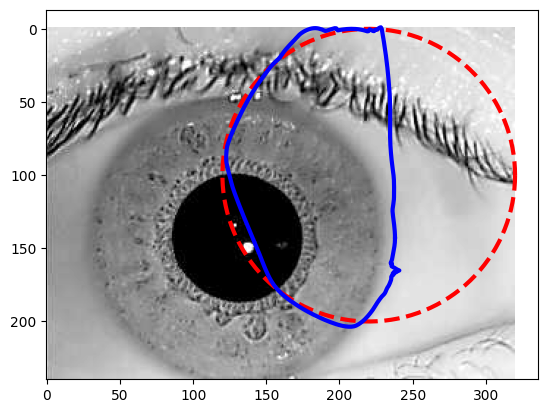

In [56]:
import cv2
import numpy as np
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt

# Load image
image_path = "testiris/01_1L.bmp"
image = cv2.imread(image_path)  # Load the image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

# Initial contour (e.g., circle around the object)
s = np.linspace(0, 2 * np.pi, 400)
x = 220 + 100 * np.cos(s)
y = 100 + 100 * np.sin(s)
init = np.array([x, y]).T

# Apply Gaussian filter to smooth the image
smoothed_image = gaussian(gray_image, 1)

# Active contour model
snake = active_contour(smoothed_image, init, alpha=0.015, beta=10, gamma=0.001)

# Plot results
fig, ax = plt.subplots()
ax.imshow(gray_image, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)  # Initial contour
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)  # Final contour
plt.show()


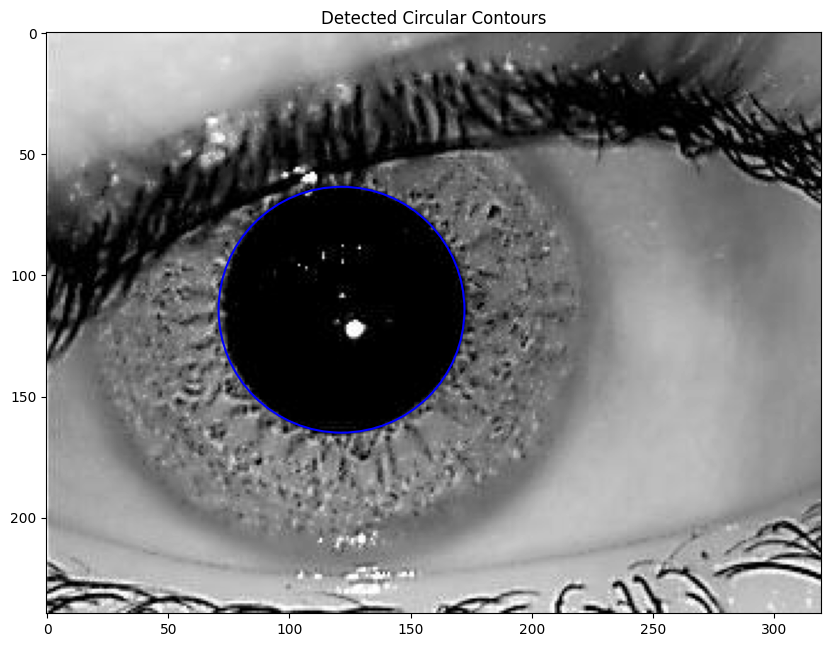

pupil centre: (121.47953796386719, 114.17007446289062), pupil radius : 48.76036071777344 


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.signal import find_peaks
from skimage.filters import gaussian
from matplotlib.patches import Circle
from scipy.ndimage import gaussian_filter


# Load the grayscale image
image_path = "testiris/01_101L.bmp"  # Update this path to the correct image file
image = io.imread(image_path, as_gray=True)


# Convert image to grayscale if it's not already
if len(image.shape) == 3:
    image = color.rgb2gray(image)

# Compute Histogram
hist, bins = np.histogram(image.ravel(), bins=256, range=[0, 1])

# Find peaks in the histogram
peaks, _ = find_peaks(hist, prominence=0.1)  # Adjust prominence as needed
if len(peaks) == 0:
    raise ValueError("No peaks found in the histogram.")
lowest_peak_intensity = bins[peaks][0]  # The first peak is the lowest intensity peak

# Choose a threshold slightly above the lowest peak intensity
threshold = lowest_peak_intensity + 0.01  # Adjust this value if necessary

# Apply Gaussian filter, keep sigma >= 1.5
sigma = 2  # Standard deviation for Gaussian kernel
smoothed_image = gaussian(image, sigma=sigma)

# Create a binary image using the threshold
binary_image = np.where(smoothed_image < threshold, 0, 255).astype(np.uint8)

# Invert the binary image for morphological operations
inverted_binary = cv2.bitwise_not(binary_image)

# Define a kernel for morphological operations (9x9)
kernel = np.ones((9, 9), np.uint8)

# Perform morphological closing to fill holes
closed_image = cv2.morphologyEx(inverted_binary, cv2.MORPH_CLOSE, kernel)

# Invert the image back to original binary format
binary_image = cv2.bitwise_not(closed_image)

# Apply the Canny edge detector
#edges = cv2.Canny(binary_image, threshold1=threshold, threshold2=255)
# Find contours in the binary edge image using OpenCV
contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# Visualize only the circular contours on the original image
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')

pupil_centre =None
pupil_radius = None
# Loop through each contour and check if it is circular
for contour in contours:
    # Fit a minimum enclosing circle to the contour
    (x, y), radius = cv2.minEnclosingCircle(contour)
    
    # Calculate the area of the contour and the circle
    contour_area = cv2.contourArea(contour)
    circle_area = np.pi * (radius ** 2)
    
    # Check if the contour is circular and ignore small 
    if 0.7<= contour_area / circle_area <= 1.2 and radius>=20:  # Adjust the range as necessary
        contour = contour.squeeze()  # Remove extra dimensions
        #plt.plot(contour[:, 1], contour[:, 0],linewidth=2, color='red')  # Corrected indexing
        pupil_centre = (x,y)
        pupil_radius = radius
        # Optionally, draw the enclosing circle on the plot
        circle = plt.Circle((x, y), radius+2, color='blue', fill=False, linewidth=1.5)
        plt.gca().add_patch(circle)

plt.title('Detected Circular Contours')
plt.show()

print(f"pupil centre: {pupil_centre}, pupil radius : {pupil_radius} ")



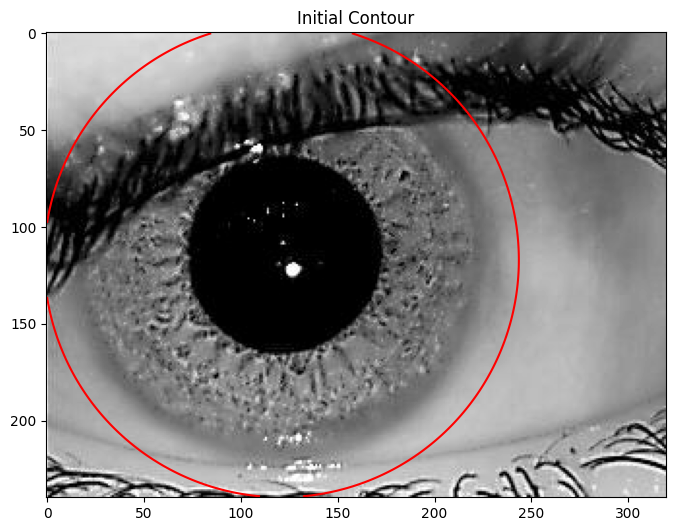

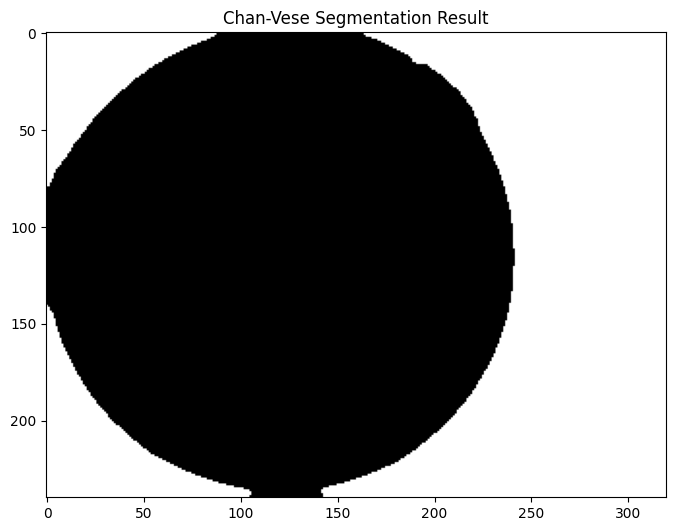

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, img_as_float
from skimage.segmentation import chan_vese



# Define the circle function with adjusted parameters
def circle_function(shape, xc, yc, rp, k, scale_factor=2.5):
    """
    shape: Shape of the image (height, width)
    xc, yc: Center coordinates of the pupil
    rp: Radius of the pupil
    k: Shift in y-axis to avoid upper eyelid texture
    scale_factor: Factor to scale the pupil radius to match iris size
    """
    rows, cols = shape
    Y, X = np.ogrid[:rows, :cols]
    
    # Calculate distance from the center adjusted for k and scale_factor
    distance = np.sqrt((X - xc)**2 + (Y - (yc + k))**2)
    circle = distance - scale_factor * rp
    
    return circle

# Parameters (These need to be estimated or fine-tuned for each image)
center_x, center_y = pupil_centre
center_x = int(round(center_x))
center_y = int(round(center_y))  # Ensure this is correctly assigned
pupil_radius = int(round(pupil_radius))  #radius detected by my own algo
k =  3         # Example shift value (replace with actual value)

# Generate the initial contour using the circle function
initial_contour = circle_function(image.shape, center_x, center_y, pupil_radius, k)

# Plot the initial contour
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.contour(initial_contour, [0], colors='r')
plt.title("Initial Contour")
plt.show()

# Apply Chan-Vese active contour model
cv_result = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=200, dt=0.5, init_level_set=initial_contour)

# Plot the final segmentation result
plt.figure(figsize=(8, 8))
plt.imshow(cv_result, cmap='gray')
plt.title("Chan-Vese Segmentation Result")
plt.show()
